# Summary plot

__last update__: 16/05/22

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
import copy
import numpy as np
import pickle as pkl
from astropy.io import fits
from scipy.optimize import minimize
import seaborn as sns # for nicer colors on the plot

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, ListedColormap, TwoSlopeNorm
from matplotlib import patches as mpatches
plt.rc('image', interpolation='none', origin='lower')
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

from herculens.Util.plot_util import nice_colorbar, nice_colorbar_residuals

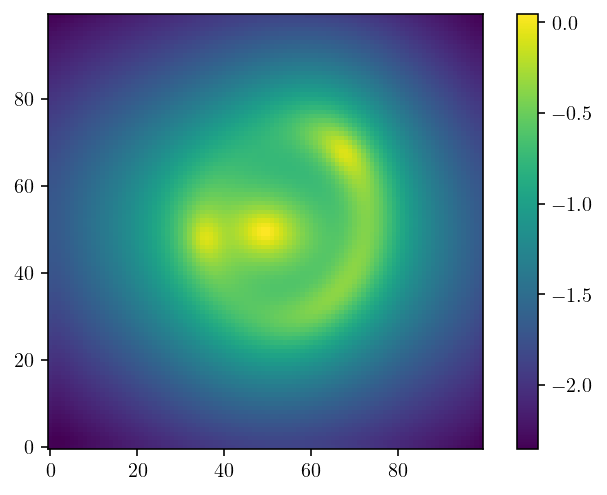

In [2]:
SAVE_FIGURES = True
figure_dir = 'figures'

# WARNING: make sure to get the correct fits file below 
data_no_pert = fits.getdata(os.path.join('molet', 'molet_sim_no_pert_newnoise', 
                                         'output', 'OBS_gaussian03.fits'), header=False)
data_no_pert_no_noise = fits.getdata(os.path.join('molet', 'molet_sim_no_pert_no_noise_newnoise', 
                                                  'output', 'OBS_gaussian03_no_noise.fits'), header=False)

plt.imshow(np.log10(data_no_pert_no_noise))
plt.colorbar()
plt.show()

In [3]:
# Define some custom colormaps
#try:
#    import palettable
#except ImportError:
#    cmap_base = plt.get_cmap('cubehelix')
#else:
#    cmap_base = palettable.cubehelix.Cubehelix.make(name='flux_colormap',
#                                                    start=0.5,
#                                                    rotation=-1,
#                                                    gamma=0.8,
#                                                    sat=0.8,
#                                                    n=256).mpl_colormap
cmap_base = copy.copy(plt.get_cmap('magma'))
cmap_base.set_under('black')
cmap_base.set_over('white')
cmap_flux = copy.copy(cmap_base)
cmap_flux.set_bad(color='black')
cmap_flux_alt = copy.copy(cmap_base)
cmap_flux_alt.set_bad(color='#222222')  # to emphasize non-positive pixels in log scale
cmap_res = plt.get_cmap('RdBu_r')
cmap_corr = copy.copy(plt.get_cmap('Spectral_r'))
cmap_corr_cut = ListedColormap(cmap_corr(np.linspace(0.5, 1, 128)))
cmap_default = plt.get_cmap('viridis')
cmap_default_cut = ListedColormap(cmap_default(np.linspace(0.5, 1, 128)))
cmap_deriv1 = plt.get_cmap('cividis')
cmap_deriv2 = plt.get_cmap('inferno')

In [4]:
# types of potential perturbations we consider
scale_factor = 2
scenario = 'real'
perturb_types = {
    f'{scenario}-dark_halo_newnoise': ("localized subhalo", "LS"), 
    f'{scenario}-GRF_newnoise': ("population of subhalos", "PS"), 
    f'{scenario}-discyness_newnoise': ("high-order moments", "HM")
}

# for each case, load the saved data from the modeling
full_model_data, smooth_model_data, pixsrc_model_data = {}, {}, {}
for perturb_type in perturb_types.keys():
    with open(os.path.join('results', f'sumplot-{perturb_type}-scale_{scale_factor}-smooth_source.pkl'), 'rb') as f:
        content = pkl.load(f)
        full_model_data[perturb_type] = content
    with open(os.path.join('results', f'sumplot-{perturb_type}-smooth_potential-smooth_source.pkl'), 'rb') as f:
        content = pkl.load(f)
        smooth_model_data[perturb_type] = content
    with open(os.path.join('results', f'sumplot-{perturb_type}-smooth_potential-wavelet_source.pkl'), 'rb') as f:
        content = pkl.load(f)
        pixsrc_model_data[perturb_type] = content

In [5]:
def levels_for_source(image, frac_levels=[0.5], n=1000):
    """compute specific levels from an image, based on fraction of the total flux.
    Useful for getting an (approximated) half-light radius from an image.
    Note that 'total light' here is defined as the sum of the `image` pixels.
    """
    from scipy import interpolate
    z = np.array(image)
    t = np.linspace(0.0, z.max(), n)
    integral = ((z >= t[:, None, None]) * z).sum(axis=(1, 2))
    f = interpolate.interp1d(integral, t)
    levels = f(np.array(frac_levels) * z.sum())
    return levels

In [6]:
def set_column_title(ax, title, fontsize=16):
    ax.text(0.5, 1.05, title, transform=ax.transAxes, 
            ha='center', va='bottom', fontsize=fontsize)
def set_row_title(ax, title, fontsize=16):
    ax.text(0, 0.5, title, transform=ax.transAxes, 
            ha='left', va='center', fontsize=fontsize)
    
def add_scale_bar(ax, extent, pixel_size, size_arcsec=1, bar_width_pixel=1, 
                  position=None, color='white', fontsize=16):
    if position is None:
        position = (extent[0]+5*pixel_size, extent[2]+5*pixel_size)
    width, height = size_arcsec, bar_width_pixel*pixel_size
    bar = mpatches.Rectangle(position, width, height, facecolor=color)
    ax.add_patch(bar)
    text_offset_y = 2 * height
    text = '{}"'.format(size_arcsec)
    ax.text(position[0]+width/2., position[1]+text_offset_y, text, color=color, fontsize=fontsize, 
            horizontalalignment='center', verticalalignment='bottom')

def add_title_box(ax, text, fontsize=16, txt_color='white', bg_color='black'):
    ax.text(0.05, 0.95, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.5})
    
def add_text_box(ax, text, loc='right', fontsize=16, txt_color='black', bg_color='white'):
    if loc == 'right':
        x, y = 0.95, 0.05
        ha, va = 'right', 'bottom'
    elif loc == 'left':
        x, y = 0.05, 0.05
        ha, va = 'left', 'bottom'
    ax.text(x, y, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment=ha, verticalalignment=va,
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.7})
    
def add_imshow_inset(ax, image, edge_color='white', **kwargs_imshow):
    w, h = 0.35, 0.35 # relative to ax size
    ax_ins = ax.inset_axes([-0.05, 1.05-h, w, h])
    ax_ins.set_xticks([]); ax_ins.set_yticks([])
    im_ins = ax_ins.imshow(image, **kwargs_imshow)
    im_ins.set_rasterized(True)
    ax_ins.spines['bottom'].set_color(edge_color)
    ax_ins.spines['top'].set_color(edge_color)
    ax_ins.spines['left'].set_color(edge_color)
    ax_ins.spines['right'].set_color(edge_color)
    return ax_ins

0 ('localized subhalo', 'LS')
derivatives() got an unexpected keyword argument 'theta_E'
1 ('population of subhalos', 'PS')


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: No contour levels were found within the data range.


variance of potential (FoV): 0.0004912113842908945
variance of potential (mask): 0.00040428897939001423
mean deflection field (mask): 0.022931624
2 ('high-order moments', 'HM')
variance of potential (FoV): 8.546293526492004e-05
variance of potential (mask): 3.293174796454692e-05
mean deflection field (mask): 0.0056249904


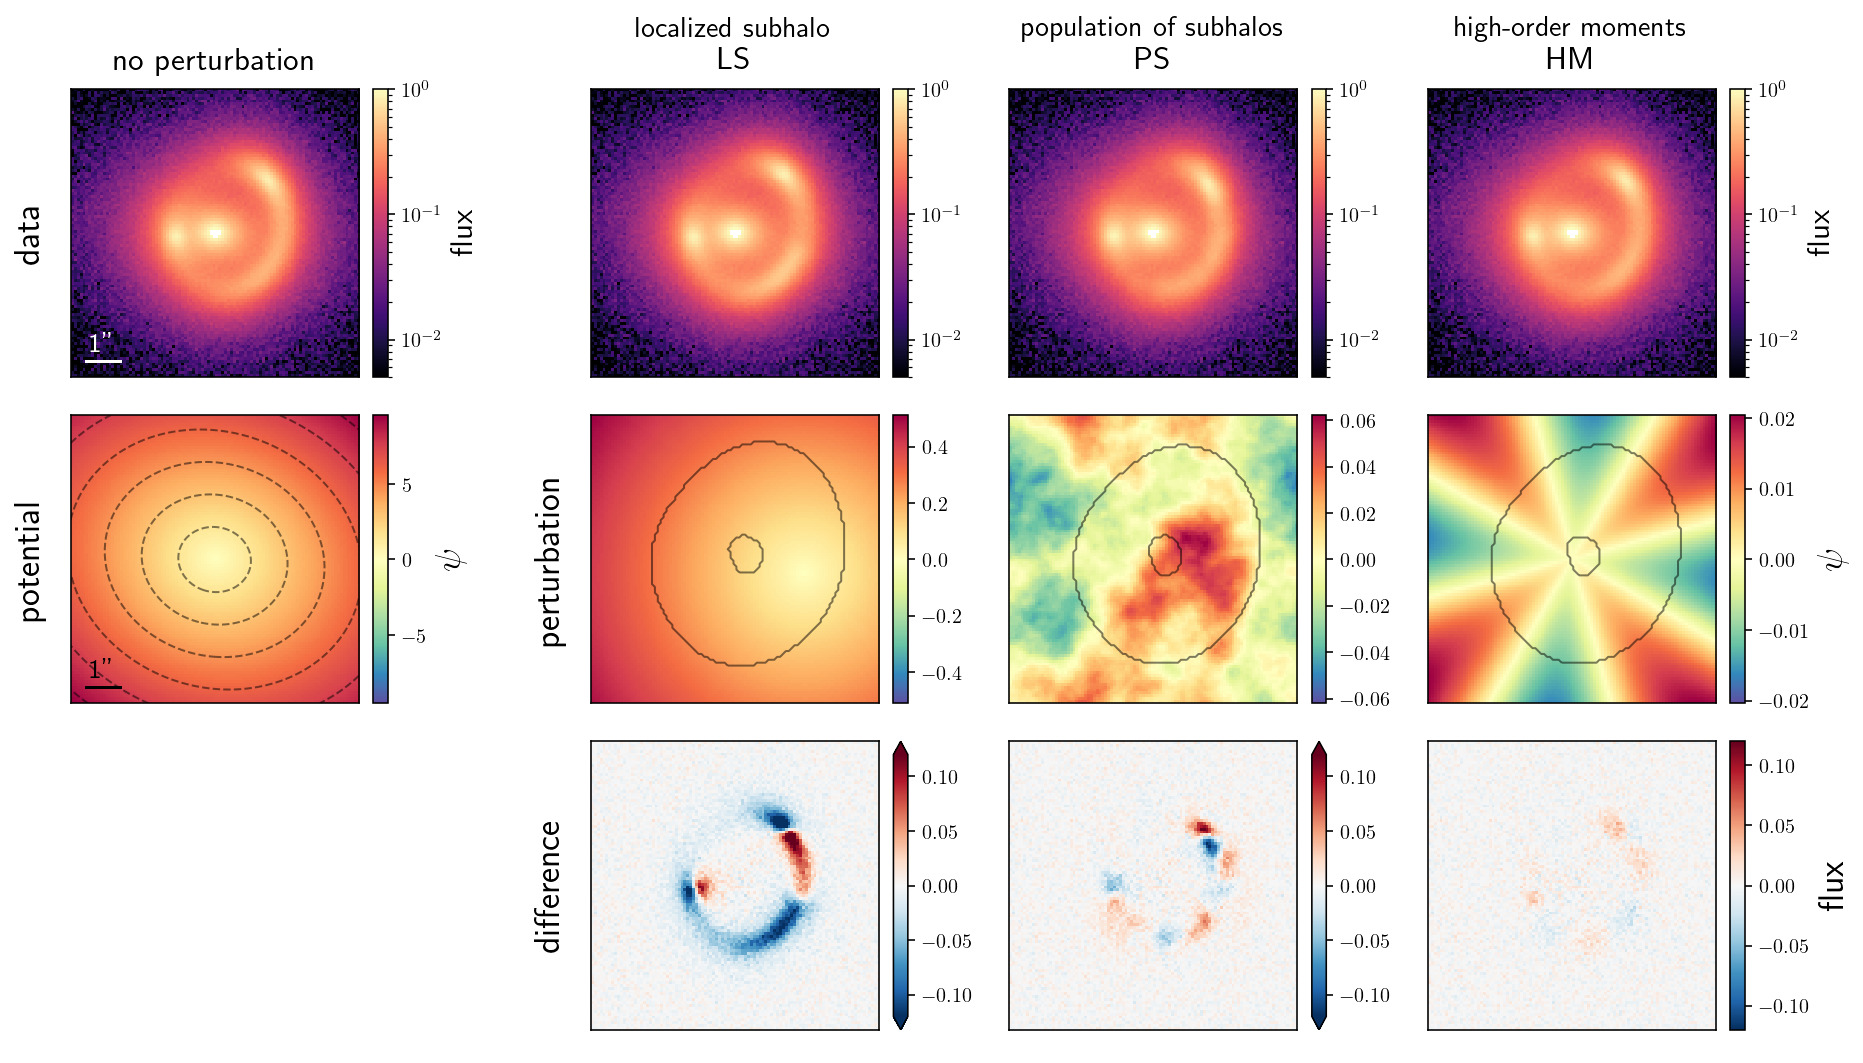

In [9]:
fontsize = 16

norm_flux = LogNorm(5e-3, 1e0)
norm_diff = Normalize(-0.12, 0.12)
norm_res = Normalize(-6, 6)

use_common_pot_vmax = False  # or None 
common_pot_vmax = 0.04

cb_pad = 0.1

num_rows = 3
num_cols = 2+len(perturb_types)
fig, axes = plt.subplots(num_rows, num_cols,
                         gridspec_kw={'width_ratios':[1]+[0.001]+[1]*len(perturb_types)},
                         figsize=(15, 9))

# remove all ticks from axes
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    
for i, (perturb_type, perturb_name) in enumerate(perturb_types.items()):
    
    print(i, perturb_name)
    
    ###################
    
    # load all necessary data
    data, full_lens_image, full_kwargs_result, input_kwargs_result, \
        _, potential_noise_map, \
        perturb_input, perturb_input_fitgrid, \
        _, cov_matrix_pixpot, _, _, _, _ \
        = full_model_data[perturb_type]
    smooth_lens_image, smooth_kwargs_result = smooth_model_data[perturb_type][1:3]
    pixsrc_lens_image, pixsrc_kwargs_result = pixsrc_model_data[perturb_type][1:3]
    
    extent = full_lens_image.Grid.extent
    pixel_size = full_lens_image.Grid.pixel_width
    x_grid, y_grid = full_lens_image.Grid.pixel_coordinates
    x_grid_fit, y_grid_fit = full_lens_image.Grid.model_pixel_coordinates('lens')
    
    lensed_source = full_lens_image.model(**full_kwargs_result, lens_light_add=False)
    noise_map = np.sqrt(full_lens_image.Noise.C_D_model(full_lens_image.model(**full_kwargs_result, lens_light_add=False)))
    source_snr = lensed_source/noise_map
    #source_levels = levels_for_source(lensed_source, frac_levels=[0.8])
    #source_levels = [0.05*np.max(lensed_source)]
    #source_mask = np.where(lensed_source > source_levels[0])
    source_mask = (source_snr > 5)
    
    full_potential_no_pert = full_lens_image.LensModel.potential(x_grid, y_grid, 
                                                                 input_kwargs_result['kwargs_lens'], 
                                                                 k=[True, True, False])
    full_potential = full_potential_no_pert + perturb_input
    
    try:
        alpha_pert = full_lens_image.LensModel.alpha(x_grid, y_grid, 
                                                     input_kwargs_result['kwargs_lens'],
                                                     k=[False, False, True])
        print("variance of potential (FoV):", np.var(perturb_input))
        print("variance of potential (mask):", np.var(perturb_input[source_mask]))
        print("mean deflection field (mask):", np.hypot(*alpha_pert)[source_mask].mean())
    except Exception as e:
        print(e)
 
    ###################
    
    # misc
    last_col = (i == len(perturb_types)-1)
    
    # first column
    if i == 0:
        # 0.1) data without perturbations
        ax = axes[0, 0]
        set_column_title(ax, "no perturbation", fontsize=fontsize)
        im = ax.imshow(data_no_pert, extent=extent, norm=norm_flux, cmap=cmap_flux)
        im.set_rasterized(True)
        nice_colorbar(im, pad=cb_pad, label="flux",
                      fontsize=fontsize, invisible=False)
        add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                      color='white', fontsize=fontsize-2)
        #add_text_box(ax, "data", fontsize=fontsize, txt_color='white', bg_color='black')
        ax.text(-0.14, 0.5 , "data", fontsize=fontsize+2, rotation=90, ha='center', va='center',
                transform=ax.transAxes)

        # 0.2) full potential
        ax = axes[1, 0]
        vmax = np.abs(full_potential_no_pert).max()
        im = ax.imshow(full_potential_no_pert, extent=extent, norm=Normalize(-vmax, vmax), cmap=cmap_corr, alpha=1)
        im.set_rasterized(True)
        ax.contour(full_potential_no_pert, extent=extent, colors='black', 
                   linestyles='--', linewidths=1, alpha=0.5)
        nice_colorbar(im, pad=cb_pad, label=r"$\psi$", 
                      colorbar_kwargs={'shrink': 0.8},
                      fontsize=fontsize+2, invisible=False)
        add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                      color='black', fontsize=fontsize-2)
        #add_text_box(ax, "potential", fontsize=fontsize, txt_color='black', bg_color='white')
        ax.text(-0.14, 0.5 , "potential", fontsize=fontsize+2, rotation=90, ha='center', va='center',
                transform=ax.transAxes)
        
        axes[0, 1].axis('off')
        axes[1, 1].axis('off')
        axes[2, 1].axis('off')
        
        axes[2, 0].axis('off')
        #ax = axes[2, 0]
        #smooth_residuals = (data_no_pert_no_noise - data_no_pert) / noise_map
        #im = ax.imshow(smooth_residuals, extent=extent, norm=norm_res, cmap=cmap_res)
        #im.set_rasterized(True)
        #label = "norm. residuals" if last_col else None
        #cb = nice_colorbar_residuals(im, smooth_residuals, vmin=norm_res.vmin, vmax=norm_res.vmax,
        #                             pad=cb_pad, label=label,
        #                            fontsize=fontsize+2, invisible=False)
    
    
    # remaining columns
    
    # 0.1) data without perturbations
    ax = axes[0, i+2]
    set_column_title(ax, r"{\Large "+f"{perturb_name[0]}"+"}"+f"\n{perturb_name[1]}", fontsize=fontsize)
    im = ax.imshow(data, extent=extent, norm=norm_flux, cmap=cmap_flux)
    im.set_rasterized(True)
    label = r"flux" if last_col else None
    nice_colorbar(im, pad=cb_pad,  label=label, 
                  fontsize=fontsize, invisible=False)

    # 0.2) full potential
    ax = axes[1, i+2]
    if use_common_pot_vmax:
        vmax = common_pot_vmax
    else:
        vmax = np.abs(perturb_input).max()
        if perturb_type == 'dark halo':
            vmax *= 0.2
    im = ax.imshow(perturb_input, extent=extent, norm=Normalize(-vmax, vmax), cmap=cmap_corr)
    im.set_rasterized(True)
    #ax.contour(full_potential, extent=extent, colors='black', linestyles='--', linewidths=1, alpha=0.5)
    ax.contour(source_mask, extent=extent, levels=[1], colors='black', linestyles='-', linewidths=1, alpha=0.5)
    #ax.contour(lensed_source, levels=source_levels, 
    #           extent=extent, colors='black', 
    #           linestyles='-', linewidths=1, alpha=0.7)
    label = r"$\psi$" if last_col else None
    if perturb_type == 'dark halo':
        cb = nice_colorbar_residuals(im, perturb_input, pad=cb_pad, label=label, 
                                vmin=-vmax, vmax=vmax,
                                fontsize=fontsize+2, invisible=False)
    else:
        cb = nice_colorbar(im, pad=cb_pad, label=label, 
                                #vmin=norm_pot.vmin, vmax=norm_pot.vmax,
                                fontsize=fontsize+2, invisible=False)
    if i == 0:
        ax.text(-0.14, 0.5 , "perturbation", fontsize=fontsize+2, rotation=90, ha='center', va='center',
                transform=ax.transAxes)
    #if not last_col:
    #    cb.set_ticks([])
    
    
    
    # 0.3) residuals
    ax = axes[2, i+2]
    smooth_difference = data_no_pert_no_noise - data
    smooth_residuals = smooth_difference / noise_map
    im = ax.imshow(smooth_difference, extent=extent, norm=norm_diff, cmap=cmap_res)
    #im = ax.imshow(smooth_residuals, extent=extent, norm=norm_res, cmap=cmap_res)
    #im = ax.imshow(data_no_pert_no_noise - data, extent=extent)
    im.set_rasterized(True)
    label = "flux" if last_col else None
    cb = nice_colorbar_residuals(im, smooth_residuals, vmin=norm_res.vmin, vmax=norm_res.vmax,
                                 pad=cb_pad, label=label,
                                fontsize=fontsize+2, invisible=False)
    if i == 0:
        ax.text(-0.14, 0.5 , "difference", fontsize=fontsize+2, rotation=90, ha='center', va='center',
                transform=ax.transAxes)


        
#line_x_pos = 0.323
#line = plt.Line2D([line_x_pos, line_x_pos], [0.145, 0.9], linewidth=4, transform=fig.transFigure, color="black")
#fig.add_artist(line)
    
fig.subplots_adjust(hspace=0., wspace=0.4)
plt.show()


In [10]:
if SAVE_FIGURES:
    figure_name = 'data_summary.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), dpi=300, bbox_inches='tight', transparent=False)